In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from Load_from_postgres import load_data

In [3]:

# Load data from PostgreSQL
data = load_data()

# Check if data was loaded successfully
if data is not None:
    print("Data loaded successfully!")
    data.head() # Display the first few rows of the DataFrame
else:
    print("Failed to load data.")

Data loaded successfully!


In [4]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
data.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [6]:
def fill_missing_values(Data):
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]):
            # Fill numeric columns with the mean
            mean_value = data[column].mean()
            data[column].fillna(mean_value, inplace=True)
        else:
            # Fill non-numeric columns with the mode
            mode_value = data[column].mode()[0]  # Get the first mode
            data[column].fillna(mode_value, inplace=True)

# Apply the function
fill_missing_values(data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24160\724285368.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(mean_value, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_24160\724285368.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [9]:

# Aggregate session frequency, duration, and total traffic per customer
user_engagement = data.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Total session duration
    'Total DL (Bytes)': 'sum',  # Total downloaded data
    'Total UL (Bytes)': 'sum',  # Total uploaded data
}).reset_index()

# Total traffic (DL + UL)
user_engagement['Total Traffic'] = user_engagement['Total DL (Bytes)'] + user_engagement['Total UL (Bytes)']

# Calculate session frequency (assumed to be the count of sessions per user)
user_engagement['Session Frequency'] = data.groupby('MSISDN/Number')['Bearer Id'].count().values

# Top 10 customers per engagement metric
top_10_duration = user_engagement.nlargest(10, 'Dur. (ms)')
top_10_traffic = user_engagement.nlargest(10, 'Total Traffic')
top_10_frequency = user_engagement.nlargest(10, 'Session Frequency')

print("Top 10 customers by session duration:")
print(top_10_duration[['MSISDN/Number', 'Dur. (ms)']])



Top 10 customers by session duration:
       MSISDN/Number   Dur. (ms)
13180   3.362578e+10  18553754.0
6437    3.361489e+10   9966898.0
92923   3.376054e+10   9279434.0
13526   3.362632e+10   8791927.0
65118   3.366716e+10   8744914.0
50281   3.366284e+10   6614270.0
57160   3.366469e+10   6288730.0
666     3.360313e+10   6287761.0
66029   3.366746e+10   5649882.0
92577   3.376041e+10   5321667.0


In [10]:
print("Top 10 customers by total traffic:")
print(top_10_traffic[['MSISDN/Number', 'Total Traffic']])


Top 10 customers by total traffic:
       MSISDN/Number  Total Traffic
6437    3.361489e+10   8.846226e+09
92923   3.376054e+10   8.514774e+09
13180   3.362578e+10   8.499621e+09
13526   3.362632e+10   7.971167e+09
76363   3.367588e+10   7.891111e+09
37052   3.365973e+10   7.705863e+09
63028   3.366646e+10   7.308501e+09
92577   3.376041e+10   7.132371e+09
57241   3.366471e+10   6.872018e+09
86455   3.369879e+10   6.540899e+09


In [11]:

print(" Top 10 customers by session frequency:")
print(top_10_frequency[['MSISDN/Number', 'Session Frequency']])

 Top 10 customers by session frequency:
       MSISDN/Number  Session Frequency
13526   3.362632e+10                 18
6437    3.361489e+10                 17
13180   3.362578e+10                 17
37052   3.365973e+10                 16
76363   3.367588e+10                 15
92923   3.376054e+10                 15
65118   3.366716e+10                 13
666     3.360313e+10                 12
1279    3.360452e+10                 12
13994   3.362708e+10                 12


Clustering (k=5)
normalizing metrics (session frequency, duration, total traffic) and apply k-means clustering.

In [16]:
# Normalize the data for clustering
scaler = StandardScaler()
engagement_metrics = user_engagement[['Session Frequency', 'Dur. (ms)', 'Total Traffic']]
engagement_metrics_scaled = scaler.fit_transform(engagement_metrics)

# Apply K-means clustering (k=5)
kmeans = KMeans(n_clusters=5, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(engagement_metrics_scaled)

# View cluster assignments
user_engagement.head()


,MSISDN/Number,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Total Traffic,Session Frequency,Cluster
0,3.360100e+10,116720.0,8.426375e+08,36053108.0,8.786906e+08,1,1
1,3.360100e+10,181230.0,1.207552e+08,36104459.0,1.568596e+08,1,3
2,3.360100e+10,134969.0,5.566597e+08,39306820.0,5.959665e+08,1,1
3,3.360101e+10,49878.0,4.019932e+08,20327526.0,4.223207e+08,1,3
4,3.360101e+10,37104.0,1.363130e+09,94280527.0,1.457411e+09,2,0


calculate min, max, average, and total for my each cluster.

In [18]:
# Calculate summary statistics for each cluster
cluster_summary = user_engagement.groupby('Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Traffic': ['min', 'max', 'mean', 'sum']
}).reset_index()

cluster_summary


Cluster Session Frequency                       Dur. (ms)              \
                        min max      mean    sum        min         max   
0       0                 1   4  2.106887  47997    18235.0   1573420.0   
1       1                 0   2  0.996314  38927     7142.0    622980.0   
2       2                 2  11  3.877137  19281    66594.0   2083209.0   
3       3                 0   2  1.025332  40840     7189.0   1035261.0   
4       4                 3  18  7.305000   1461  1322251.0  18553754.0   

                              Total Traffic                              \
           mean           sum           min           max          mean   
0  2.022847e+05  4.608247e+09   177006936.0  2.034468e+09  1.049019e+09   
1  1.011358e+05  3.951478e+09   466372928.0  1.553585e+09  7.069074e+08   
2  4.748296e+05  2.361327e+09   542935647.0  5.096129e+09  2.042863e+09   
3  1.046521e+05  4.168397e+09    33249009.0  5.242892e+08  2.866126e+08   
4  2.646939e+06  5.293878e+08   743040941.0  8.846226e+09  3.704761e+09   

                 
            sum  
0  2.389769e+13  
1  2.761958e+13  
2  1.015916e+13  
3  1.141607e+13  
4  7.409521e+11

Application Traffic
Aggregate total traffic per application and identify the top 10 most engaged users for each app.

In [21]:
# Aggregate total traffic per application for each user
application_traffic = data.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum'
}).reset_index()

# Calculate total traffic for each application (DL + UL)
application_traffic['Total Social Media'] = application_traffic['Social Media DL (Bytes)'] + application_traffic['Social Media UL (Bytes)']
application_traffic['Total Google'] = application_traffic['Google DL (Bytes)'] + application_traffic['Google UL (Bytes)']
application_traffic['Total Email'] = application_traffic['Email DL (Bytes)'] + application_traffic['Email UL (Bytes)']
application_traffic['Total Youtube'] = application_traffic['Youtube DL (Bytes)'] + application_traffic['Youtube UL (Bytes)']
application_traffic['Total Netflix'] = application_traffic['Netflix DL (Bytes)'] + application_traffic['Netflix UL (Bytes)']

# Find the top 10 users per application
top_10_social_media = application_traffic.nlargest(10, 'Total Social Media')
top_10_google = application_traffic.nlargest(10, 'Total Google')
top_10_youtube = application_traffic.nlargest(10, 'Total Youtube')

print("Top 10 most engaged users in Social Media:")
print(top_10_social_media[['MSISDN/Number', 'Total Social Media']])



Top 10 most engaged users in Social Media:
        MSISDN/Number  Total Social Media
13526    3.362632e+10          43374779.0
92923    3.376054e+10          39783189.0
37052    3.365973e+10          35412358.0
6437     3.361489e+10          28294544.0
13180    3.362578e+10          27135500.0
65118    3.366716e+10          24247850.0
106137   3.378632e+10          23974919.0
70960    3.366907e+10          23800834.0
666      3.360313e+10          23077825.0
31331    3.365849e+10          23000066.0


In [22]:

print("Top 10 most engaged users in Google:")
print(top_10_google[['MSISDN/Number', 'Total Google']])



Top 10 most engaged users in Google:
        MSISDN/Number  Total Google
13526    3.362632e+10   152191852.0
13180    3.362578e+10   142307915.0
6437     3.361489e+10   127973787.0
92923    3.376054e+10   123223099.0
37052    3.365973e+10   116516345.0
106137   3.378632e+10   110254484.0
76363    3.367588e+10   109860502.0
65118    3.366716e+10   105032696.0
94654    3.376127e+10    97089988.0
86313    3.369876e+10    91935151.0


In [23]:
print("Top 10 most engaged users in YouTube:")
print(top_10_youtube[['MSISDN/Number', 'Total Youtube']])

Top 10 most engaged users in YouTube:
       MSISDN/Number  Total Youtube
13180   3.362578e+10    452958769.0
92923   3.376054e+10    396289198.0
6437    3.361489e+10    394370218.0
13526   3.362632e+10    374483047.0
76363   3.367588e+10    317410572.0
65118   3.366716e+10    315231310.0
13994   3.362708e+10    308790774.0
92577   3.376041e+10    303169107.0
86455   3.369879e+10    302661958.0
666     3.360313e+10    284090139.0


Top 3 Apps Usage Statistics
I will now plot usage statistics for the top 3 apps (Social Media, Google, and YouTube).

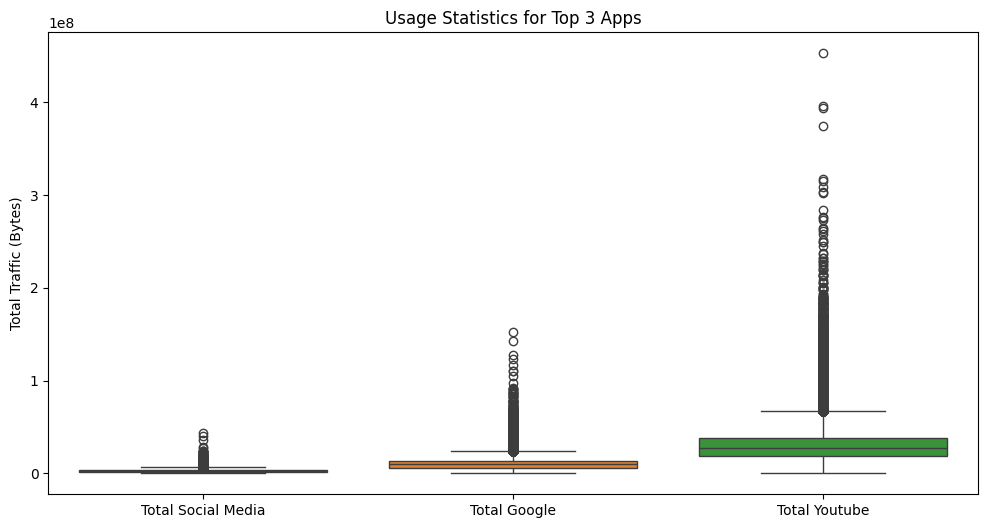

In [24]:
# Plot usage statistics for top 3 apps
plt.figure(figsize=(12, 6))
sns.boxplot(data=application_traffic[['Total Social Media', 'Total Google', 'Total Youtube']])
plt.title('Usage Statistics for Top 3 Apps')
plt.ylabel('Total Traffic (Bytes)')
plt.show()


Optimized k Clusters (Elbow Method)
I will use the elbow method to find the optimal number of clusters for engagement metrics.

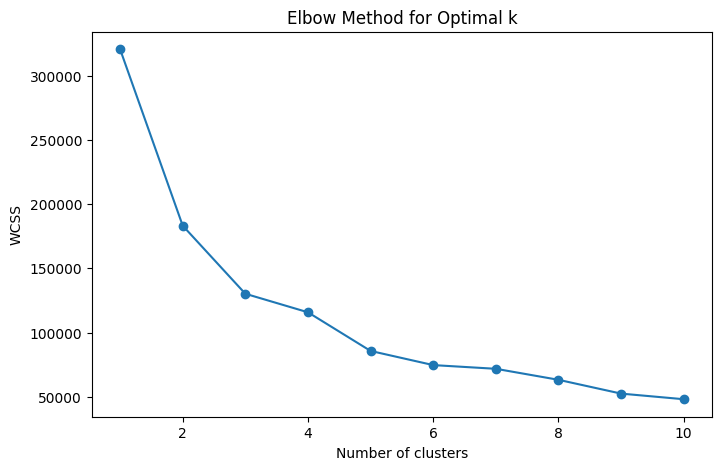

In [25]:
# Use the elbow method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(engagement_metrics_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
